<a id="contents"></a>
#### Оглавление:
1. Импорт библиотек, загрузка датасетов
2. Предобработка данных
3. Приоритизация гипотез:
- Фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Вывод как изменилась приоритизация гипотез при применении RICE вместо ICE. 
4. Анализ A/B-теста
- График кумулятивной выручки по группам. 
- График кумулятивного среднего чека по группам. 
- График относительного изменения кумулятивного среднего чека группы B к группе A. 
- График кумулятивной конверсии по группам. 
- График относительного изменения кумулятивной конверсии группы B к группе A.
- Точечный график количества заказов по пользователям. 
- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, выберим границу для определения аномальных пользователей.
- Точечный график стоимостей заказов. 
- Посчитаем 95-й и 99-й перцентили стоимости заказов, выберим границу для определения аномальных заказов.
- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 
- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
5. Принятие решения, общий вывод по проекту.
 

In [1]:
# импортируем необходмые библиотеки
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import datetime as dt
from tqdm import tqdm
import warnings
from math import ceil
import plotly.graph_objects as go
import pathlib
from pathlib import Path
warnings.filterwarnings('ignore')
#pd.set_option('max_columns', None)
pd.options.display.float_format= '{:.3f}'.format
#%config InlineBackend.figure_format = 'svg'

In [2]:
# загрузим датасеты
hypothesis=pd.read_csv('hypothesis.csv', sep=',')
orders=pd.read_csv('orders.csv', sep=',')
visitors=pd.read_csv('visitors.csv', sep=',')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
#заменим верхний регистр на нижний 
hypothesis.columns = hypothesis.columns.str.lower()
list(hypothesis)

['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


##### <a href="#contents">2. Предобработка данных</a> 

In [8]:
# переименуем названия столбцов на корректные
orders=orders.rename(columns={'transactionId':'transaction_id',
                             'visitorId':'visitor_id'})

In [9]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
# заменим в столбце с датой тип данных 
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#orders['date']=pd.to_datetime(orders['date'], format='%Y-%m-%d)   

In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# заменим в столбце с датой тип данных 
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
orders.duplicated().sum()

0

In [15]:
visitors.duplicated().sum()

0

In [16]:
hypothesis.duplicated().sum()

0

In [17]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [18]:
# посмотрим пользователей, попавших сразу в обе группы
users_groups = orders.groupby(['visitor_id'])['group'].nunique().reset_index()
users_groups

,visitor_id,group
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


In [19]:
# выделим этих пользователей и посчитаем процент от общего количества пользователей
anomal = users_groups [users_groups ['group'] >1]['visitor_id']
anomal_ratio = len(anomal) / len(orders['visitor_id']) 
print('Всего пользователей, попавших в две разные группы в тесте: {:.2f}% от общего количества пользователей'.format(anomal_ratio*100))

Всего пользователей, попавших в две разные группы в тесте: 4.85% от общего количества пользователей


In [20]:
# таких пользователей оказалось немного, отрежем их 
orders = orders[~orders['visitor_id'].isin(anomal)]

##### Вывод:
Предобработка завершена, в таблице orders заменили названия: убрали верхний регистр, заменили названия на более понятные, также столбец date привели к временному формату; таблица visitors также имеет столбец с датой: заменили на временной формат. Также в таблице hypothesis в названиях столбцов заменили верхний регистр на нижний. Дупликатов и пропусков в датасетах нет. Можно проводить дальнейшие исследования.

##### <a href="#contents">3. Приоритизация гипотез</a> 

##### <a href="#contents">Применим фреймворк ICE для приоритизации гипотез, отсортируем их по убыванию приоритета.</a>  

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)
hypothesis_path = Path(pathlib.Path.cwd(), 'datasets', 'bestsellers with categories.csv')
#hypothesis = pd.read_csv(data_path)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [22]:
hypothesis['ICE'] = (
    hypothesis['impact'] * hypothesis['confidence']
) / hypothesis['efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)

In [23]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)\
    .style.background_gradient('RdPu', subset=['ICE'])\
    .set_properties(subset=['hypothesis'], **{'width': '800px', 'text-align':'left'})
                                                                                                   

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


##### <a href="#contents">Применим фреймворк RICE для приоритизации гипотез, отсортируем их по убыванию приоритета.</a>  

In [24]:
hypothesis['RICE'] = ((
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']
) / hypothesis['efforts']).round(2)

In [25]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)\
    .style.background_gradient('RdPu', subset=['RICE'])\
    .set_properties(subset=['hypothesis'], **{'width': '800px', 'text-align':'left'})

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


##### Вывод: 
Наиболее перспективные гипотезы при применении ICE: 

8 - Запустить акцию, дающую скидку на товар в день рождения,
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, 
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Тогда как при применении RICE наиболее перпективные гипотезы уже другие:

7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа, 
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Так произошло, потому что параметр reach=10 для гипотезы 7 - самый высокий балл, при применении ICE 
параметр reach вообще не учитывается.

##### <a href="#contents">Анализ А/В-теста</a> 

##### <a href="#contents">Построим график кумулятивной выручки по группам.</a> 

In [26]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [27]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


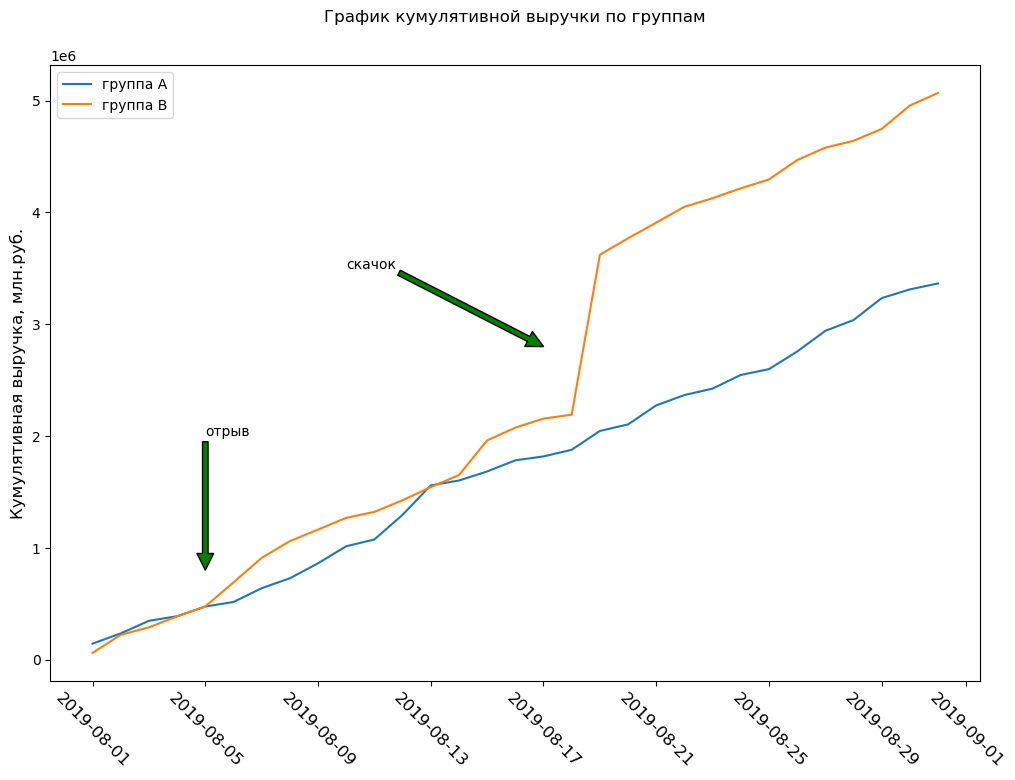

In [28]:
# создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# соберём агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'visitor_id': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединим обе таблицы в одну с понятными названиями столбцов
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

# Строим график выручки группы А
fig = plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа B')

plt.annotate('скачок', xy=(np.datetime64('2019-08-17'), 2800000), xytext=(np.datetime64('2019-08-10'), 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy= (np.datetime64('2019-08-05'), 800000), xytext=(np.datetime64('2019-08-05'), 2000000),
            arrowprops=dict(facecolor='g'))
plt.title('График кумулятивной выручки по группам\n\n', fontsize=(12))
plt.ylabel('Кумулятивная выручка, млн.руб.',fontsize=(12))
#plt.xlabel('Дата',fontsize=(14))
plt.xticks(rotation=-45, fontsize=12)
plt.legend()
plt.show()

##### Вывод:
Можно сказать, что выручка в обеих выручках увеличивается, только в группе В резко идет вверх в промежутке между 2019-08-17 и 2019-08-21. Выручка группы А равномерно увеличивается на протяжении рассматриваемого периода. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

##### <a href="#contents">Построим график кумулятивного среднего чека по группам.</a> 

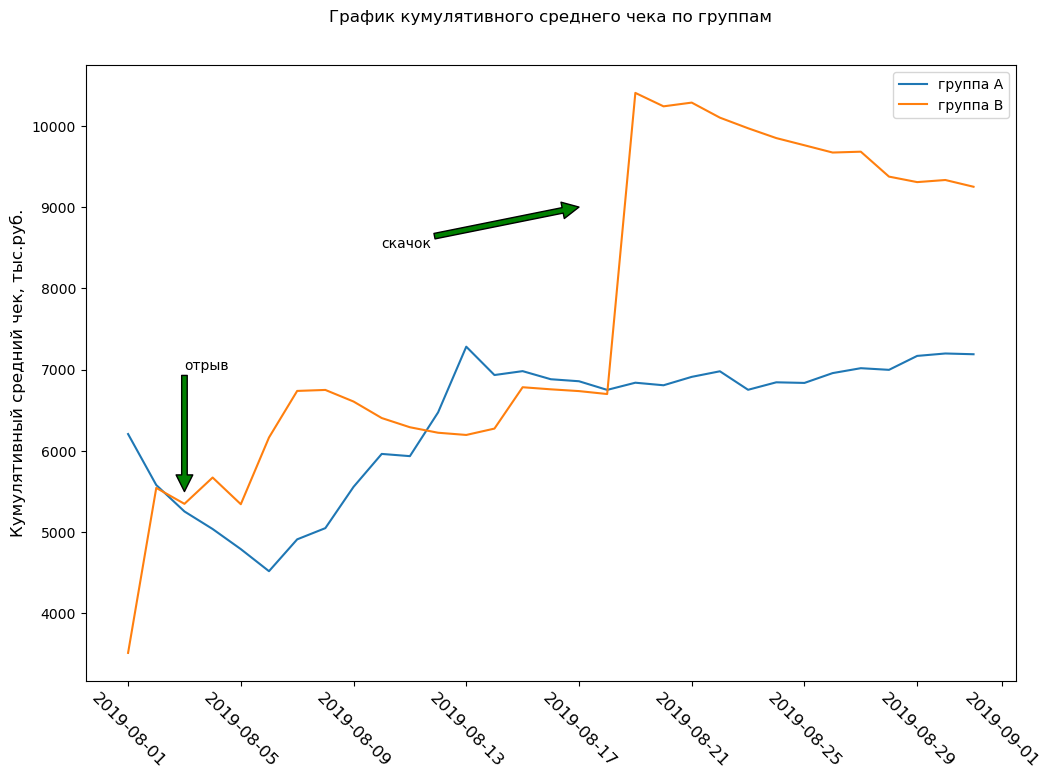

In [29]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
fig = plt.figure(figsize=(12,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')

plt.annotate('скачок', xy=(np.datetime64('2019-08-17'), 9000), xytext=(np.datetime64('2019-08-10'), 8500),
             arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=(np.datetime64('2019-08-03'), 5500), xytext=(np.datetime64('2019-08-03'), 7000),
            arrowprops=dict(facecolor='g'))
             
plt.title('График кумулятивного среднего чека по группам\n\n', fontsize=(12))
plt.ylabel('Кумулятивный средний чек, тыс.руб.', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
plt.legend()
plt.show()

##### Вывод:
Средний чек ведет себя по разному: в группе В делает резкий скачок вверх и затем немного снижается. Средний чек в группе А тоже имеет небольшой всплеск в начале теста, но к концу теста стабилизируется, это хороший знак. Возможно, в группу B в середине проведения теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

##### <a href="#contents">Построим график относительного различия для среднего чека группы В к группе А.</a> 

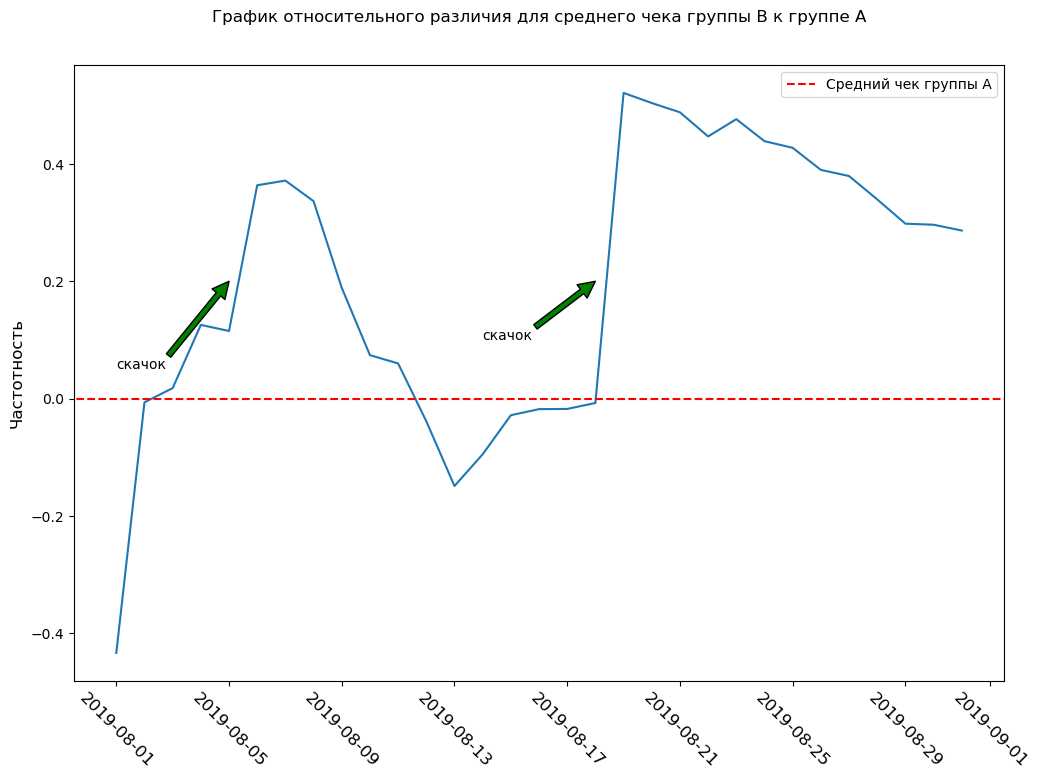

In [30]:
# Построим график относительного различия для среднего чека
# собираем данные в одном датафрейме

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,\
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков

fig = plt.figure(figsize=(12,8))
ax = plt.axes()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.annotate('скачок', xy=(np.datetime64('2019-08-18'), 0.2), xytext=(np.datetime64('2019-08-14'), 0.1),
             arrowprops=dict(facecolor='g'))
plt.annotate('скачок', xy=(np.datetime64('2019-08-05'), 0.2), xytext=(np.datetime64('2019-08-01'), 0.05),
            arrowprops=dict(facecolor='g'))

# добавляем ось X

plt.axhline(0, -0.5, 11.5, color='red', label='Средний чек группы А', linestyle='--') 

plt.title('График относительного различия для среднего чека группы В к группе А\n\n', fontsize=(12))
plt.ylabel('Частотность', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
ax.legend(fontsize=12)
plt.legend()
plt.show()

##### Вывод:
В нескольких точках график различия между сегментами резко «скачет». Значит необходимо будет найти крупные заказы и выбросы.

##### <a href="#contents">Построим график кумулятивной конверсии по группам.</a>

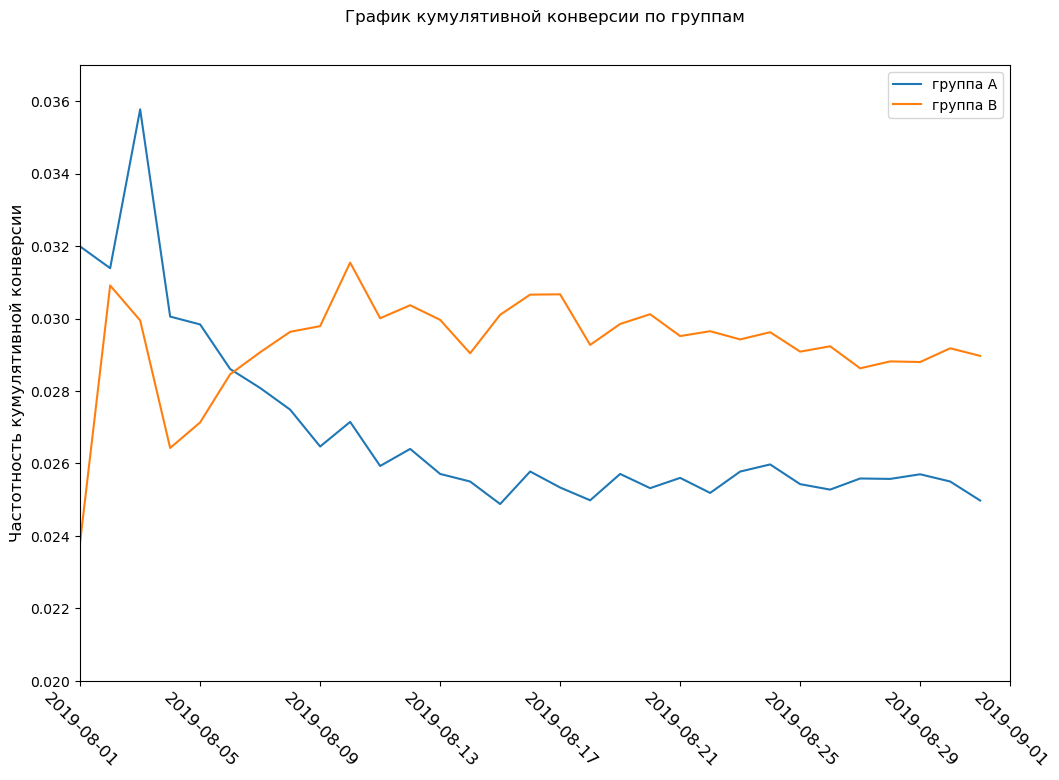

In [31]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

fig = plt.figure(figsize=(12,8))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа B')
plt.legend()

# задаем масштаб осей
plt.axis([(np.datetime64("2019-08-01")), (np.datetime64('2019-09-01')), 0.02, 0.037]) 

plt.title('График кумулятивной конверсии по группам\n\n', fontsize=(12))
plt.ylabel('Частотность кумулятивной конверсии', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
plt.legend()
plt.show()

##### Вывод:
Графики практически идентичны. В обеих группах был небольшой всплеск, затем график группы А просел и зафиксировался. График группы В немного подрос и тоже зафиксировался.

##### <a href="#contents">Построим график относительного изменения кумулятивной конверсии группы B к группе A.</a>

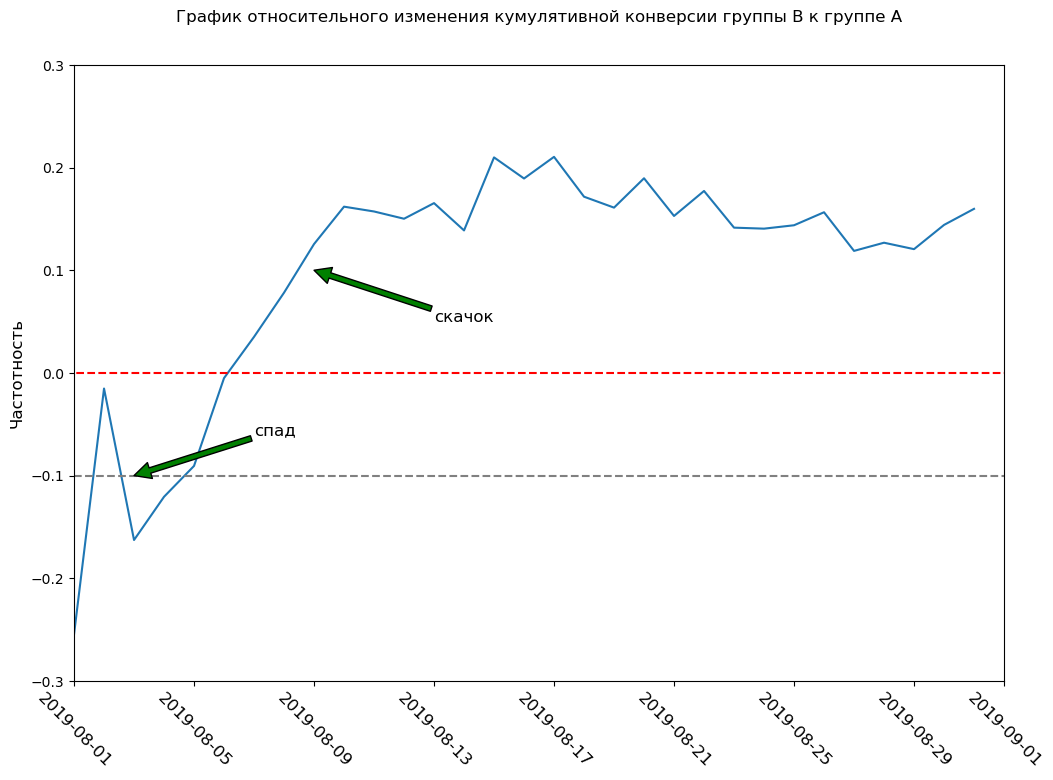

In [32]:
# построим график относительного изменения кумулятивной конверсии группы В к группе А

mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1, label="График изменения кумулятивной конверсии группы B относительно группы A")

# добавим комментарии

plt.annotate('скачок', xy=(np.datetime64('2019-08-09'), 0.1), xytext=(np.datetime64('2019-08-13'), 0.05),
             arrowprops=dict(facecolor='g'), fontsize=(12))
plt.annotate('спад', xy=(np.datetime64('2019-08-03'), -0.1), xytext=(np.datetime64('2019-08-07'), -0.06),
             arrowprops=dict(facecolor='g'), fontsize=(12))

# добавляем ось X

plt.axhline(0, -0.5, 11.5, color='red', label='Кумулятивная конверсия группы А', linestyle='--') 
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A\n\n', fontsize=(12))
plt.ylabel('Частотность', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
#ax.legend(fontsize=12)
plt.axis([(np.datetime64("2019-08-01")), (np.datetime64('2019-09-01')), -0.3, 0.3])
plt.show()

##### Вывод: 
В начале теста группа B незначительно проигрывала группе A, затем вырвалась вперёд, и стабилизировалась в конце теста. 
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

##### <a href="#contents">Построим точечный график количества заказов по пользователям.</a>

In [33]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


#### Вывод: 
в основном, пользователи совершали 3 заказа. Построим теперь гистограмму

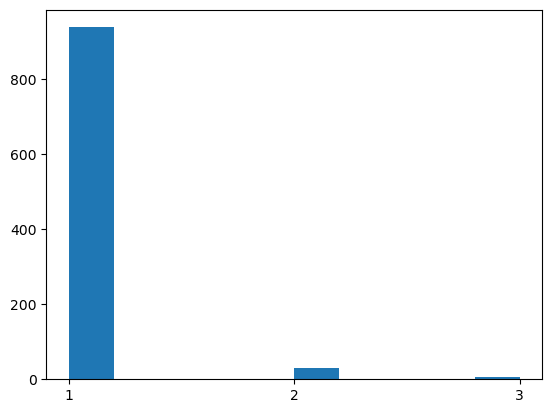

In [34]:
plt.hist(ordersByUsers['orders'])
plt.xticks(np.arange(1, 4))
#plt.xlabel()
plt.show()

##### Вывод: 
по графику видно, что большинство пользователей совершают один заказ, но также есть пользователи, совершающие 2 заказа, их доля значительна, также есть существенно меньшее число покупателей 3 заказами. Построим теперь точечный график.

In [35]:
class Image:
    def __init__(self, title=None, x=12, y=3, legend=False, grid=False):
        self.title= title
        self.x = x
        self.y = y
        self.legend = legend
        self.grid = grid

    def __enter__(self):
         plt.figure(figsize=(self.x, self.y), dpi=180)

    def __exit__(self, *args):
        if self.legend:
            plt.figlegend()
        if self.grid:
            plt.grid()
        plt.suptitle(self.title)
        plt.show()
        plt.close()

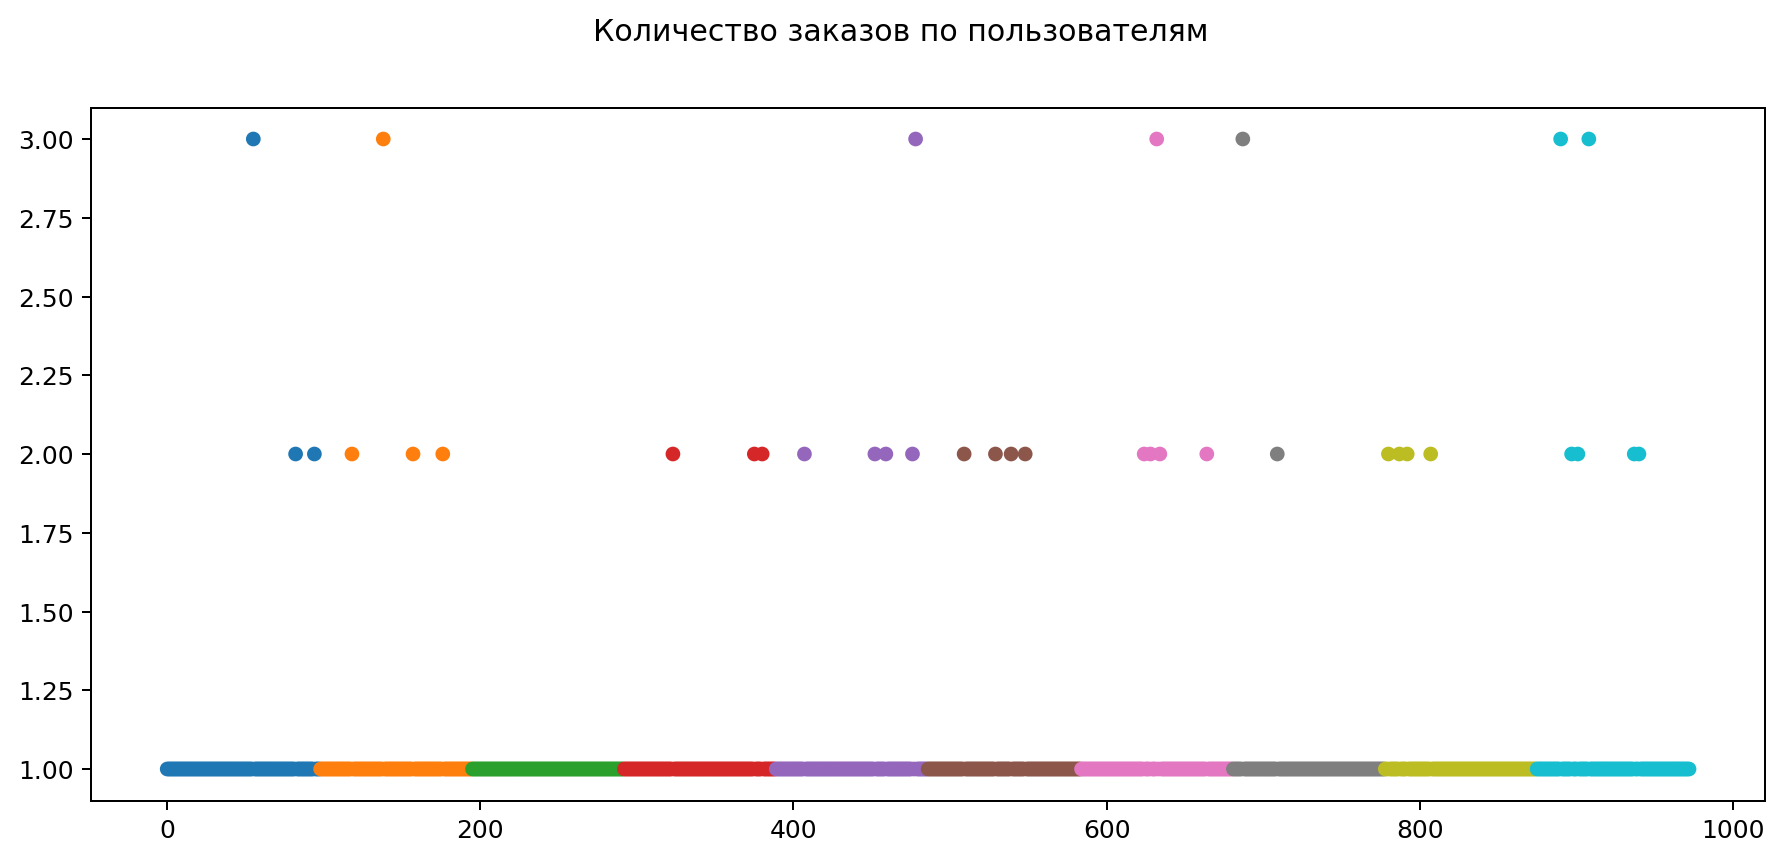

In [36]:
with Image('Количество заказов по пользователям', y=5):
    x_values = pd.Series(range(0,len(ordersByUsers)))
    colors = [plt.cm.tab10(i/float(len(x_values)-1)) for i in range(len(x_values))]
    plt.scatter(x_values, ordersByUsers['orders'], s=15, alpha=1, c=colors, linewidths=2, edgecolors="face")
    #plt.xticks(fontsize=3)
    #plt.yticks(fontsize=3)
    #plt.legend(fontsize=5)   
    #plt.gcf().autofmt_xdate() 

#### Выводы подтверждаются: 
много пользователей с 2-3 заказами, их точная доля неясна, поэтому мы не можем считать их аномалиями. Посчитаем 90, 95, 99 перцентили.

##### <a href="#contents">Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, выберем границу для определения аномальных пользователей.</a>

In [37]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 1. 2.]


##### Вывод:
не более 5% пользователей совершали 1 покупку, не более 1% совершили 2 заказа. Думаю, будет логичным выбрать 2 заказа за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

##### <a href="#contents">Построим точечный график стоимостей заказов.</a>

In [38]:
pd.set_option('display.max_row', 25)
#pd.set_option('display.max_columns', 25)
pd.options.display.max_colwidth = 150 
display(orders.sort_values(by='revenue', ascending=False))

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
...,...,...,...,...,...
404,2052514069,1995481842,2019-08-28,70,B
933,3760662696,3577713868,2019-08-27,60,B
584,1126146019,2705308997,2019-08-20,50,A
756,125335873,3423937755,2019-08-30,50,B


##### Вывод: 
отсортировав стоимости по убыванию, можно сказать диапазон сумм 30000 и выше  - это аномально высокие суммы. Посмотрим на гистограмму

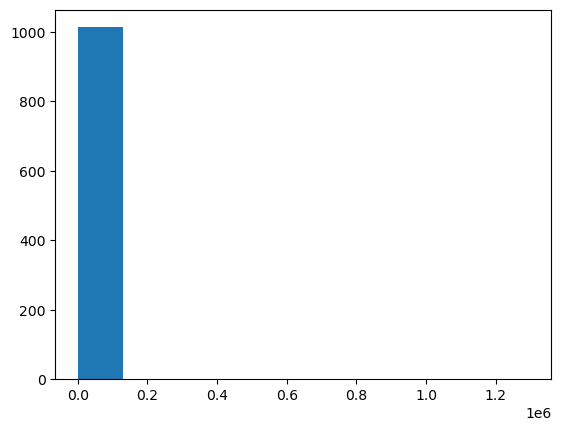

In [39]:
plt.hist(orders['revenue'])
plt.show()

##### Вывод:
видим, что гистограмма в данном случае - совершенно не показательный график, стоит посмотреть на точечный график.

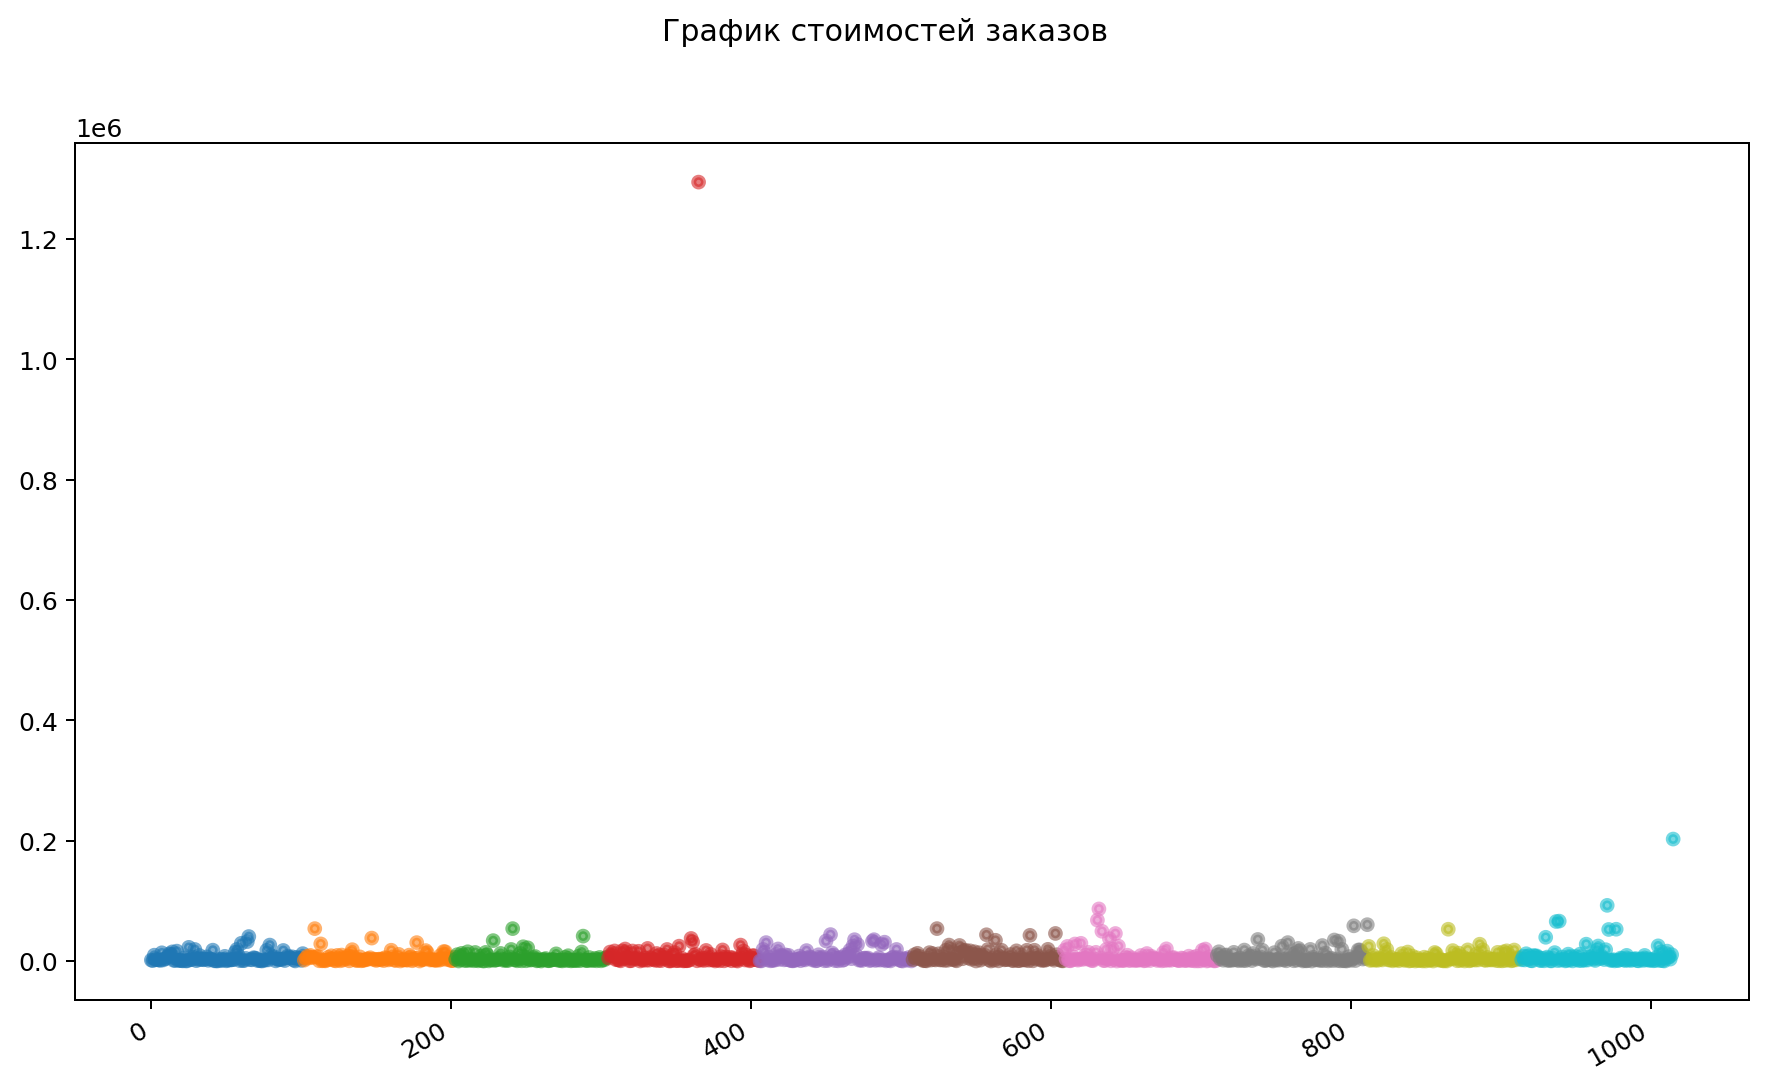

In [40]:
with Image('График стоимостей заказов', y=7):
    x_values = pd.Series(range(0,len(orders['revenue'])))
    colors = [plt.cm.tab10(i/float(len(x_values)-1)) for i in range(len(x_values))]
    plt.scatter(x_values, orders['revenue'], s=15, alpha=.6, c=colors, linewidths=2, edgecolors="face")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    #plt.legend(fontsize=10)   
    plt.gcf().autofmt_xdate() 

##### Вывод:
на точечном графике теперь видны редкие заказы, что подтверждается сортировкой выше. Но все не совсем очевидно, что же считать нижней границей стоимости заказов, посчитаем 95 и 99 перцентили.

##### <a href="#contents">Посчитаем 95-й и 99-й перцентили стоимости заказов, выберем границу для определения аномальных заказов.</a>

In [41]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


##### Вывод:
не более 5% сумма заказов более 26785, примем за нижнюю границу аномальных заказов 25000.

##### <a href="#contents"> Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.</a> 

In [42]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [43]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [44]:
# подготовим данные для изучения, создадим сводную таблицу data

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
) 

In [45]:
# убедимся, что все получилось
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


##### Сформулируем нулевую и альтернативные гипотезы: 
    H0 = статистически значимых различий в конверсии по "сырым" данным между группами нет.
    H1 = конверсиипо "сырым" данным  между группами А и В статистически различаются

In [46]:
# Посчитаем статистическую значимость различия в конверсии между группами.
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# создадим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()\
                                                       - len(ordersByUsersA['orders'])), name='orders')]
sampleA = pd.concat([ordersByUsersA['orders'],\
                     pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum()\
                                                 - len(ordersByUsersA['orders'])), name='orders')],axis=0)
                                                        

sampleB = pd.concat([ordersByUsersB['orders'],\
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()\
                                                  - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

# Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


In [47]:
alpha=0.05
results = st.ttest_ind(sampleA, sampleB, equal_var=False) 
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.022720196169250924
Отвергаем нулевую гипотезу


##### Вывод: 
по «сырым» данным различий в конверсии групп A и B нет, p-value = 0.022 < 0.05. Это значит, что нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Однако относительный проигрыш группы B равен 16% — второе число в выводе.

##### <a href="#contents"> Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.</a> 

#####  Сформулируем нулевую и альтернативные гипотезы: 
    H0 = статистически значимых различий в среднем чеке по "сырым" данным между группами А и В нет.
    H1 = средние чеки по "сырым" данным между группами А и В статистически различаются.

In [48]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


0.829
0.287


In [49]:
alpha=0.05
results = st.ttest_ind(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.40353397129314894
Не получилось отвергнуть нулевую гипотезу


##### Вывод: 
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно ниже среднего чека группы A.

По итогам найденных перцентилей среднего чека и количества заказов, примем за аномальных пользователей, совершивших больше трех покупок на сумму больше 25000. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders  и пользователей, совершивших заказы дороже 25 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. Также посчитаем количество аномальных пользователей.
Итак, у нас не получилось отвергнуть нулевую гипотезу по итогам теста. Сделаем срезы пользователей, совершивших заказы на сумму более 50000 - аномальную сумму заказов.

In [50]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
33      249864742
58      611059232
1137    759473111
949     887908475
dtype: int64
(22,)


##### Вывод: 
всего 22 аномальных пользователя.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным

##### <a href="#contents"> Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.</a> 

In [51]:
# подготовим выборки количества заказов по пользователям по группам теста:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

##### Сформулируем нулевую и альтернативные гипотезы: 
    H0 = статистически значимых различий в конверсии по "очищенным" данным между группами А и В нет.
    H1 = конверсии по "очищенным" данным между группами А и В статистически различаются.

In [52]:
# применим статистический критерий Манна-Уитни к полученным выборкам:

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.006
0.198


In [53]:
alpha=0.05
results = st.ttest_ind(sampleAFiltered, sampleBFiltered, equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.005502752809676806
Отвергаем нулевую гипотезу


#### Вывод; 
Результаты по конверсии практически не изменились. p_value оказалось больше (0.03 < 0.05). По итогам тестов, мы отвергаем нулевую гипотезу о том, что статистичаески значимых различий в конверсии по очищенным данным межлу группами нет.

##### <a href="#contents"> Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.</a>

##### Сформулируем нулевую и альтернативные гипотезы: 
    H0 = статистически значимых различий в среднем чеке по "очищенным" данным между группами А и В нет.
    H1 = средние чеки по "очищенным" данным между группами А и В статистически различаются.

In [54]:
# посмотрим на "очищенные" результаты среднего чека: 
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.939
0.011


In [55]:
alpha=0.05
results = st.ttest_ind(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'], equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8957940455221134
Не получилось отвергнуть нулевую гипотезу


##### Вывод:
P-value снизился, разница между сегментами сократилась с 28% до 9%.

##### <a href="#contents"> Общий вывод по проекту:</a>

1. Нет статистически значимого различия по конверсии между группами ни по «сырым», ни по данным после фильтрации аномалий;

2. Появилась статистическая значимость различия по среднему чеку между группами, это означает, что после удаления выбросов в 
данных меньше шума.

##### Посмотрим на график конверсии между группами:

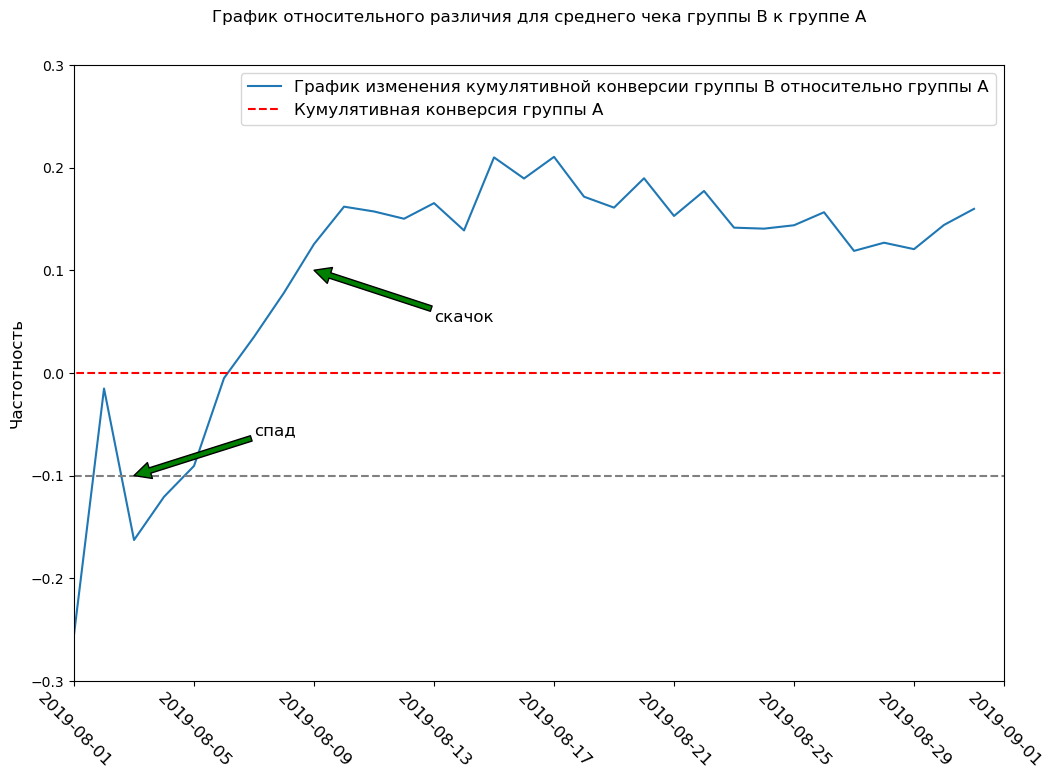

In [56]:
# построим график относительного изменения кумулятивной конверсии группы В к группе А

mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1, label="График изменения кумулятивной конверсии группы B относительно группы A")

# добавим комментарии

plt.annotate('скачок', xy=(np.datetime64('2019-08-09'), 0.1), xytext=(np.datetime64('2019-08-13'), 0.05),
             arrowprops=dict(facecolor='g'), fontsize=(12))
plt.annotate('спад', xy=(np.datetime64('2019-08-03'), -0.1), xytext=(np.datetime64('2019-08-07'), -0.06),
            arrowprops=dict(facecolor='g'), fontsize=(12))

# добавляем ось X

plt.axhline(0, -0.5, 11.5, color='red', label='Кумулятивная конверсия группы А', linestyle='--') 
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('График относительного различия для среднего чека группы В к группе А\n\n', fontsize=(12))
plt.ylabel('Частотность', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
ax.legend(fontsize=12)
plt.axis([(np.datetime64("2019-08-01")), (np.datetime64('2019-09-01')), -0.3, 0.3])
plt.show()

График различия конверсии между группами сообщает, что результаты группы B намного лучше группы A.  

##### Посмотрим на график различия среднего чека

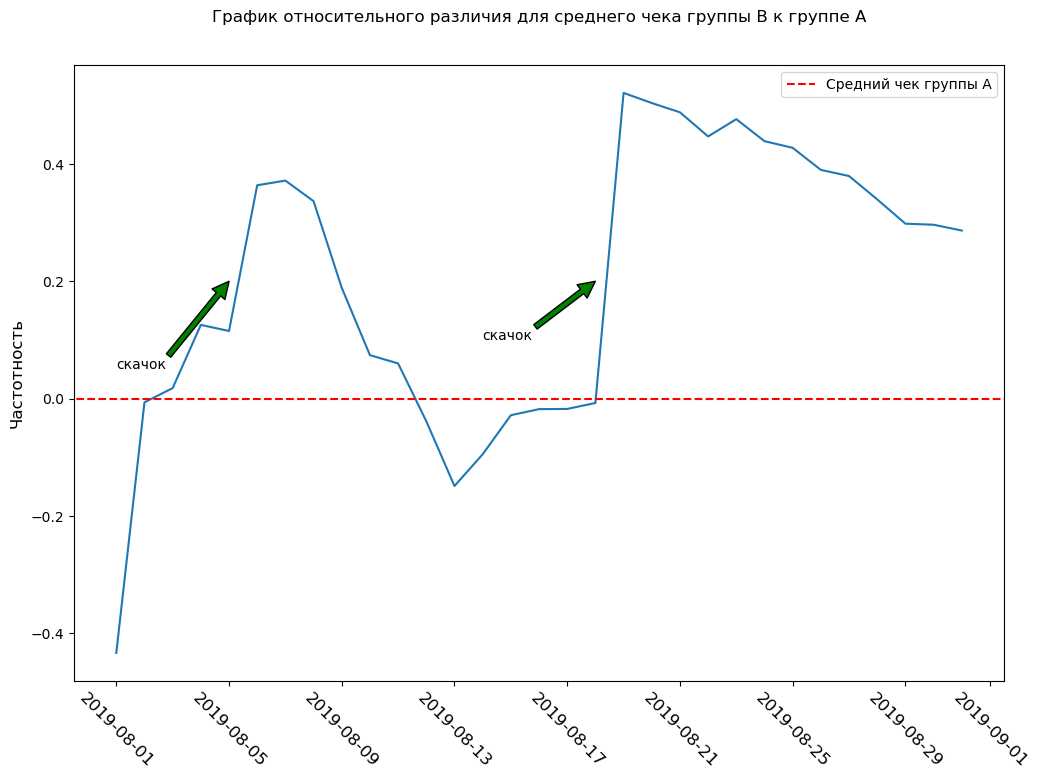

In [57]:
# Построим график относительного различия для среднего чека
# собираем данные в одном датафрейме

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,\
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков

fig = plt.figure(figsize=(12,8))
ax = plt.axes()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.annotate('скачок', xy=(np.datetime64('2019-08-18'), 0.2), xytext=(np.datetime64('2019-08-14'), 0.1),
             arrowprops=dict(facecolor='g'))
plt.annotate('скачок', xy=(np.datetime64('2019-08-05'), 0.2), xytext=(np.datetime64('2019-08-01'), 0.05),
            arrowprops=dict(facecolor='g'))

# добавляем ось X

plt.axhline(0, -0.5, 11.5, color='red', label='Средний чек группы А', linestyle='--') 

plt.title('График относительного различия для среднего чека группы В к группе А\n\n', fontsize=(12))
plt.ylabel('Частотность', fontsize=(12))             
plt.xticks(rotation=-45, fontsize=12)
ax.legend(fontsize=12)
plt.legend()
plt.show()

График различия среднего чека говорит о том, что результаты группы B намного лучше группы А  и сейчас почти на 30% лучше.

##### Вывод:
тест можно признать успешным и остановить, поскольку статистически значимых различий между группами между группами А и В нет.

##### Вывод по гипотезам при применении ICE и RICE:

Наиболее перспективные гипотезы при применении ICE: 

8 - Запустить акцию, дающую скидку на товар в день рождения,
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, 
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Тогда как при применении RICE наиболее перпективные гипотезы уже другие:

7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа, 
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Так произошло, потому что параметр reach=10 (то есть охват аудитории) для гипотезы 7 - самый высокий балл, при применении ICE 
параметр reach вообще не учитывается.